In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification # This package is used solely for generation of synthetic data (Q19).
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import datasets
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score, r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LogisticRegression
from scipy import stats
from sklearn.decomposition import PCA

# use seaborn plotting defaults
import seaborn as sns; sns.set()

## Coding problem 1 (Q19): Implement Batch Gradient Descent with early stopping for Softmax Regression (without using Scikit-Learn) 

In [5]:
np.random.seed(42) # Random seed for reproducibility

# 1. Generating synthetic data
# For softmax regression with 3 classes
X, y = make_classification(
    n_samples=300,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_classes=3,
    n_clusters_per_class=1,
    random_state=42,
    class_sep=2.5)

# Splitting into training and validation sets (for early stopping)
def train_test_split(X, y, test_size=0.2, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    
    n_samples = len(X)
    indices = np.random.permutation(n_samples)
    test_size = int(test_size * n_samples)
    
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]
    
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Adding bias term to X (intercept)
X_train_with_bias = np.c_[np.ones((X_train.shape[0], 1)), X_train]
X_val_with_bias = np.c_[np.ones((X_val.shape[0], 1)), X_val]

In [6]:
def softmax(z):
    # Note: We're keeping the shifted_z for numerical stability as removing it could cause overflow
    shifted_z = z - np.max(z, axis=1, keepdims=True)
    exp_z = np.exp(shifted_z)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

# Function to compute cross-entropy loss
def cross_entropy_loss(y_true, y_pred_proba):
    m = len(y_true)
    # Getting the predicted probability for the true class for each sample
    # Adding small epsilon to avoid log(0).
    probs = np.clip([y_pred_proba[i, y_true[i]] for i in range(m)], 1e-17, 1-1e-17)
    return -np.sum(np.log(probs)) / m

# Function which computes accuracy
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

In [7]:
# 2. Implementing Batch Gradient Descent with early stopping
class SoftmaxRegression:
    def __init__(self, alpha=0.05, max_epochs=1000, early_stopping_rounds=10, tol=1e-4): # with epsilon term (i.e. tolerance value)
        self.alpha = alpha
        self.max_epochs = max_epochs
        self.early_stopping_rounds = early_stopping_rounds
        self.tol = tol
        self.weights = None
        self.loss_history = []
        self.val_loss_history = []
        
    def fit(self, X, y, X_val, y_val):
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))
        
        # Initializing with random weights
        self.weights = np.random.randn(n_features, n_classes) * 0.01
        
        # For early stopping!
        best_val_loss = float('inf')
        no_improvement_count = 0
        best_weights = None
        
        # 3. Printing epochs and updated weights
        print(f"Initial weights:\n{self.weights}")
        
        for epoch in range(self.max_epochs):
            z = X @ self.weights
            y_pred_proba = softmax(z)
            
            # Getting the predictions
            y_pred = np.argmax(y_pred_proba, axis=1)
            
            # Computing losses
            train_loss = cross_entropy_loss(y, y_pred_proba)
            self.loss_history.append(train_loss)
            
            # Computing the validation loss and predictions
            z_val = X_val @ self.weights
            y_val_pred_proba = softmax(z_val)
            y_val_pred = np.argmax(y_val_pred_proba, axis=1)
            val_loss = cross_entropy_loss(y_val, y_val_pred_proba)
            self.val_loss_history.append(val_loss)
            
            # Accuracy
            train_acc = accuracy(y, y_pred)
            val_acc = accuracy(y_val, y_val_pred)
            
            # Printing the progress
            if epoch % 10 == 0 or epoch == self.max_epochs - 1:
                print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, "
                      f"Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")
                print(f"Updated weights:\n{self.weights}")
                
            # Early stopping check
            if val_loss < best_val_loss - self.tol:
                best_val_loss = val_loss
                no_improvement_count = 0
                best_weights = self.weights.copy()
            else:
                no_improvement_count += 1
                
            if no_improvement_count >= self.early_stopping_rounds:
                print(f"Early stopping at epoch {epoch}")
                self.weights = best_weights
                break
            
        # Computinh the gradients (batch gradient descent)
            # Here I implement the gradient directly as per the lecture notes
            gradients = np.zeros_like(self.weights)
            for i in range(n_samples):
                for j in range(n_classes):
                    # For the true class, adding (pred_prob - 1) * x
                    # For other classes, adding pred_prob * x
                    indicator = 1 if y[i] == j else 0
                    gradients[:, j] += (y_pred_proba[i, j] - indicator) * X[i, :]
            
            gradients = gradients / n_samples
            # Updating weights
            self.weights -= self.alpha * gradients
            
        return self
    
    def predict_proba(self, X):
        z = X @ self.weights
        return softmax(z)
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

In [8]:
# Training the model with batch gradient descent
model = SoftmaxRegression(alpha=0.01, max_epochs=250, early_stopping_rounds=10)
model.fit(X_train_with_bias, y_train, X_val_with_bias, y_val)

Initial weights:
[[ 0.01209382  0.0053796   0.02734422]
 [ 0.00093765 -0.01406405 -0.0003453 ]
 [-0.00963016  0.0097718   0.0004198 ]]
Epoch 0: Train Loss = 1.1151, Val Loss = 1.1146, Train Acc = 0.0250, Val Acc = 0.0500
Updated weights:
[[ 0.01209382  0.0053796   0.02734422]
 [ 0.00093765 -0.01406405 -0.0003453 ]
 [-0.00963016  0.0097718   0.0004198 ]]
Epoch 10: Train Loss = 0.8164, Val Loss = 0.8106, Train Acc = 1.0000, Val Acc = 1.0000
Updated weights:
[[ 0.01187992  0.00472249  0.02821524]
 [-0.05101329  0.08446261 -0.04692101]
 [ 0.04634688  0.05526106 -0.1010465 ]]
Epoch 20: Train Loss = 0.6312, Val Loss = 0.6249, Train Acc = 1.0000, Val Acc = 0.9833
Updated weights:
[[ 0.01009914  0.00530491  0.0294136 ]
 [-0.09567641  0.16224573 -0.08004101]
 [ 0.09295995  0.08784044 -0.18023895]]
Epoch 30: Train Loss = 0.5100, Val Loss = 0.5050, Train Acc = 1.0000, Val Acc = 0.9833
Updated weights:
[[ 0.00753704  0.00656272  0.03071788]
 [-0.13386859  0.22524838 -0.10485148]
 [ 0.13175621  0.1

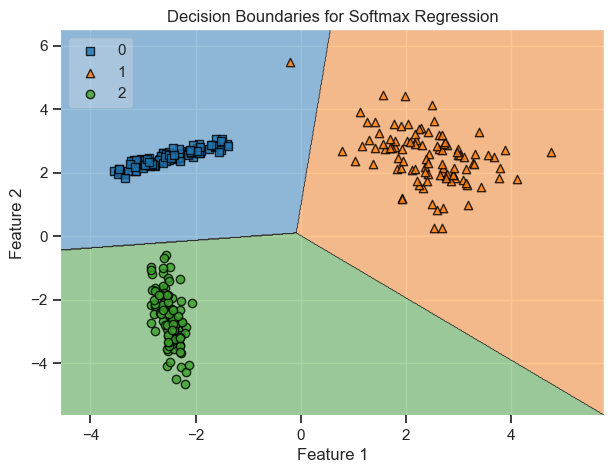

In [10]:
from mlxtend.plotting import plot_decision_regions

# Visualizing the decision boundaries using mlxtend (similar to the softmax-demo.ipynb on Moodle)
def plot_decision_boundary(X, y, model):
    plt.figure(figsize=(7, 5))

    # Remove bias column for plotting (we need only two features)
    X_plot = X[:, 1:]

    # Define a wrapper class to add bias term when predicting
    class ModelWrapper:
        def __init__(self, model):
            self.model = model

        def predict(self, X):
            # Adding bias term to match model's expectations
            X_with_bias = np.c_[np.ones((X.shape[0], 1)), X]
            return self.model.predict(X_with_bias)

    # Wrapping the model to handle the bias term (this fixed an error I experienced with this package)
    wrapped_model = ModelWrapper(model)

    plot_decision_regions(X_plot, y, clf = wrapped_model, legend=2)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundaries for Softmax Regression')
    plt.show()

X_with_bias = np.c_[np.ones((X.shape[0], 1)), X]
plot_decision_boundary(X_with_bias, y, model)

## Coding Problem 2 (Q20): Implement a simple linear regression model using gradient descent algorithm to predict salary given years of experience (data is available on Moodle), without using Scikit-Learn.

Gradient Descent - Learned parameters: theta_0 (intercept) = 25887.17, theta_1 (slope) = 8469.57

Gradient Descent Model Evaluation:
Mean Squared Error (MSE): 780390433.06
Root Mean Squared Error (RMSE): 27935.47
Mean Absolute Error (MAE): 22497.96

Scikit-Learn Model Evaluation:
Mean Squared Error (MSE): 805617048.01
Root Mean Squared Error (RMSE): 28383.39
Mean Absolute Error (MAE): 22206.92


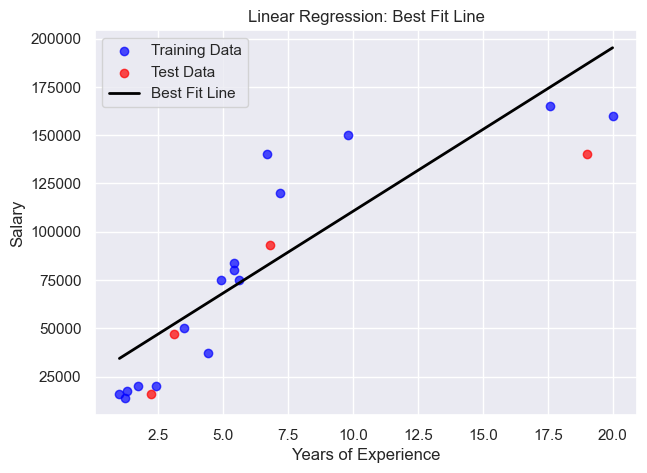

In [12]:
# Step 1: Data extraction and conversion
def read_data(file_path):
    X, Y = [], []
    with open(file_path, 'r', encoding='utf-8-sig') as file:
        for line in file:
            experience, salary = line.strip().split(', ')
            X.append(float(experience))
            Y.append(float(salary))
    return np.array(X), np.array(Y)


# Step 2: Feature Scaling (Standardization)
def standardize(X):
    return (X - np.mean(X)) / np.std(X)


# Step 3: Splitting it into train and test sets (80/20 ratio)
def train_test_split(X, Y, test_size=0.2):
    data_size = len(X)
    test_size = int(data_size * test_size)
    indices = np.random.permutation(data_size)
    
    X_train, Y_train = X[indices[:-test_size]], Y[indices[:-test_size]]
    X_test, Y_test = X[indices[-test_size:]], Y[indices[-test_size:]]
    
    return X_train, Y_train, X_test, Y_test


# Step 4: Implementing Linear Regression using GD
def linear_regression_gd(X_train, Y_train, alpha=0.011, epochs=300):
    m = len(X_train)
    
    # Initializing weights (slope and intercept)
    theta_0 = np.mean(Y_train)  # Set intercept to mean salary (better starting point)
    theta_1 = 0  # Initial slope

    loss_history = []  # To track loss over epochs

    for _ in range(epochs):
        predictions = theta_0 + theta_1 * X_train
        errors = predictions - Y_train

        # Compute gradients
        gradient_theta_0 = (2/m) * np.sum(errors)
        gradient_theta_1 = (2/m) * np.sum(errors * X_train)

        # Weight updates
        theta_0 -= alpha * gradient_theta_0
        theta_1 -= alpha * gradient_theta_1

        # Store loss (Mean Squared Error)
        loss = np.mean(errors ** 2)
        loss_history.append(loss)

    return theta_0, theta_1, loss_history


# Step 5: Defining the predict function
def predict(X, theta_0, theta_1):
    return theta_0 + theta_1 * X


# Step 6: Evaluating the model (using the following metrics: MSE, RMSE, MAE)
def evaluating_model(Y_true, Y_pred):
    mse = np.mean((Y_true - Y_pred) ** 2) 
    rmse = np.sqrt(mse)  # Root Mean Squared Error
    mae = np.mean(np.abs(Y_true - Y_pred))  # Mean Absolute Error
    return mse, rmse, mae


# Step 7: Visualization of Best Fit Line
def plot_regression(X_train, Y_train, X_test, Y_test, theta_0, theta_1):
    plt.figure(figsize=(7, 5))
    
    # Scatter plot of training and test data
    plt.scatter(X_train, Y_train, color='blue', label='Training Data', alpha=0.7)
    plt.scatter(X_test, Y_test, color='red', label='Test Data', alpha=0.7)

    # Best fit line
    X_range = np.linspace(X_train.min(), X_train.max(), 100)
    Y_pred_line = predict(X_range, theta_0, theta_1)
    plt.plot(X_range, Y_pred_line, color='black', linewidth=2, label='Best Fit Line')

    plt.xlabel("Years of Experience")
    plt.ylabel("Salary")
    plt.title("Linear Regression: Best Fit Line")
    plt.legend()
    plt.show()

# Main function to run everything
def main():
    X, Y = read_data('salary_prediction.txt')

    # Data Split
    X_train, Y_train, X_test, Y_test = train_test_split(X, Y)
    
    # Running the Simple Linear regression algorithm to get the required parameter values for the intercept and slope + capturing the loss history
    theta_0, theta_1, loss_history = linear_regression_gd(X_train, Y_train)

    # Printing the learned parameters
    print(f"Gradient Descent - Learned parameters: theta_0 (intercept) = {theta_0:.2f}, theta_1 (slope) = {theta_1:.2f}")

    # Making predictions on the test set
    Y_pred = predict(X_test, theta_0, theta_1)

    # Evaluating Gradient Descent Model
    mse, rmse, mae = evaluating_model(Y_test, Y_pred)
    print("\nGradient Descent Model Evaluation:")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")

    # Training Scikit-Learn's Linear Regression Model
    sklearn_model = LinearRegression()
    sklearn_model.fit(X_train.reshape(-1, 1), Y_train)

    # Scikit-Learn's predictions
    Y_pred_sklearn = sklearn_model.predict(X_test.reshape(-1, 1))

    # Evaluating Scikit-Learn Model
    mse_sklearn = mean_squared_error(Y_test, Y_pred_sklearn)
    rmse_sklearn = np.sqrt(mse_sklearn)
    mae_sklearn = mean_absolute_error(Y_test, Y_pred_sklearn)

    print("\nScikit-Learn Model Evaluation:")
    print(f"Mean Squared Error (MSE): {mse_sklearn:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse_sklearn:.2f}")
    print(f"Mean Absolute Error (MAE): {mae_sklearn:.2f}")

    # Visualizing the Best Fit Line (Gradient Descent vs. Scikit-Learn)
    plot_regression(X_train, Y_train, X_test, Y_test, theta_0, theta_1)

if __name__ == "__main__":
    main()

Gradient Descent - Learned parameters: theta_0 (intercept) = 20962.14, theta_1 (slope) = 8263.95

Gradient Descent Model Evaluation:
Mean Squared Error (MSE): 855860050.67
Root Mean Squared Error (RMSE): 29255.09
Mean Absolute Error (MAE): 25840.35

Scikit-Learn Model Evaluation:
Mean Squared Error (MSE): 844616662.26
Root Mean Squared Error (RMSE): 29062.29
Mean Absolute Error (MAE): 25714.78


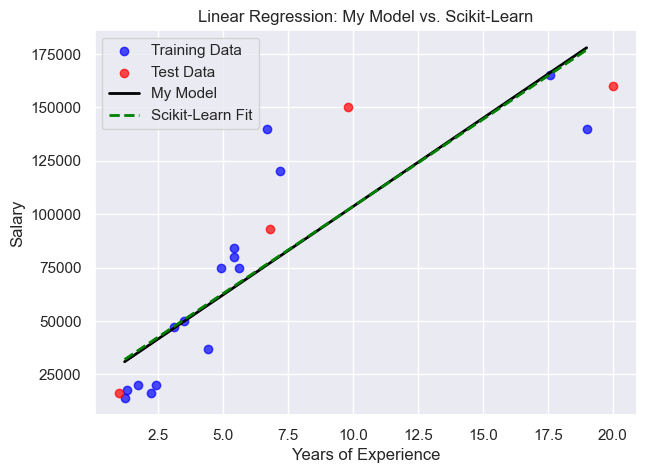

In [3]:
# Step 1: Extracting the data and converting into correct format
def read_data(path):
    X, Y = [], []
    with open(path, 'r', encoding='utf-8-sig') as file:
        for line in file:
            experience, salary = line.strip().split(', ')
            X.append(float(experience))
            Y.append(int(salary))
    return np.array(X), np.array(Y)

# Step 2: Splitting it into train and test sets (80/20 ratio)
def train_test_split(X, Y, test_size=0.2):
    data_size = len(X)
    test_size = int(data_size * test_size)
    indices = np.random.permutation(data_size)
    
    X_train, Y_train = X[indices[:-test_size]], Y[indices[:-test_size]]
    X_test, Y_test = X[indices[-test_size:]], Y[indices[-test_size:]]
    
    return X_train, Y_train, X_test, Y_test


# Step 3: Implementing Linear Regression using Gradient Descent
def linear_regression_gd(X_train, Y_train, alpha=0.011, epochs=300):
    m = len(X_train)
    
    # Initializing weights (slope and intercept)
    theta_0 = 0
    theta_1 = 0

    loss_history = []  # List to track loss with epoch iterations

    for _ in range(epochs):
        predictions = theta_0 + theta_1 * X_train
        
        errors = predictions - Y_train
        # Computing the gradients
        gradient_theta_0 = (2/m) * np.sum(errors)
        gradient_theta_1 = (2/m) * np.sum(errors * X_train)
        # Updating the weights using the adjusted parameter values received from gradient descent
        theta_0 -= alpha * gradient_theta_0
        theta_1 -= alpha * gradient_theta_1

        # Storing loss (Mean Squared Error) and adding into the list of losses
        loss = np.mean(errors ** 2)
        loss_history.append(loss)

    return theta_0, theta_1, loss_history

# Step 4: y^ predict function
def predict(X, theta_0, theta_1):
    return theta_0 + theta_1 * X


# Step 5: Evaluating the model (using the following metrics: MSE, RMSE, MAE)
def evaluating_model(Y_true, Y_pred):
    mse = np.mean((Y_true - Y_pred) ** 2)
    rmse = np.sqrt(mse)  # Root Mean Squared Error
    mae = np.mean(np.abs(Y_true - Y_pred))  # Mean Absolute Error
    return mse, rmse, mae


# Step 6: Visualization of Best Fit Line (Gradient Descent vs. Scikit-Learn)
def plot_regression(X_train, Y_train, X_test, Y_test, theta_0, theta_1, sklearn_model):
    plt.figure(figsize=(7, 5))
    
    # Scatter plot of training and test data
    plt.scatter(X_train, Y_train, color='blue', label='Training Data', alpha=0.7)
    plt.scatter(X_test, Y_test, color='red', label='Test Data', alpha=0.7)

    # Best fit line (Gradient Descent)
    X_range = np.linspace(X_train.min(), X_train.max(), 100)
    Y_pred_line_gd = predict(X_range, theta_0, theta_1)
    plt.plot(X_range, Y_pred_line_gd, color='black', linewidth=2, linestyle='-', label='My Model')

    # Best fit line (Scikit-Learn)
    Y_pred_line_sklearn = sklearn_model.predict(X_range.reshape(-1, 1))
    plt.plot(X_range, Y_pred_line_sklearn, color='green', linewidth=2, linestyle='--', label='Scikit-Learn Fit')

    plt.xlabel("Years of Experience")
    plt.ylabel("Salary")
    plt.title("Linear Regression: My Model vs. Scikit-Learn")
    plt.legend()
    plt.show()


# Main function to run everything
def main():
    X, Y = read_data('salary_prediction.txt')

    # Data Split
    X_train, Y_train, X_test, Y_test = train_test_split(X, Y)
    
    # Running the Simple Linear regression algorithm to get the required parameter values for the intercept and slope + capturing the loss history
    theta_0, theta_1, loss_history = linear_regression_gd(X_train, Y_train)

    # Printing the learned parameters
    print(f"Gradient Descent - Learned parameters: theta_0 (intercept) = {theta_0:.2f}, theta_1 (slope) = {theta_1:.2f}")

    # Making predictions on the test set
    Y_pred = predict(X_test, theta_0, theta_1)

    # Evaluating Gradient Descent Model
    mse, rmse, mae = evaluating_model(Y_test, Y_pred)
    print("\nGradient Descent Model Evaluation:")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")

    # Training Scikit-Learn's Linear Regression Model
    sklearn_model = LinearRegression()
    sklearn_model.fit(X_train.reshape(-1, 1), Y_train)

    # Scikit-Learn's predictions
    Y_pred_sklearn = sklearn_model.predict(X_test.reshape(-1, 1))

    # Evaluating Scikit-Learn Model
    mse_sklearn = mean_squared_error(Y_test, Y_pred_sklearn)
    rmse_sklearn = np.sqrt(mse_sklearn)
    mae_sklearn = mean_absolute_error(Y_test, Y_pred_sklearn)

    print("\nScikit-Learn Model Evaluation:")
    print(f"Mean Squared Error (MSE): {mse_sklearn:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse_sklearn:.2f}")
    print(f"Mean Absolute Error (MAE): {mae_sklearn:.2f}")

    # Visualizing the Best Fit Line (Gradient Descent vs. Scikit-Learn)
    plot_regression(X_train, Y_train, X_test, Y_test, theta_0, theta_1, sklearn_model)

if __name__ == "__main__":
    main()

---
# Q21: Generate a non linear data, and implement a polynomial regression model to fit the data

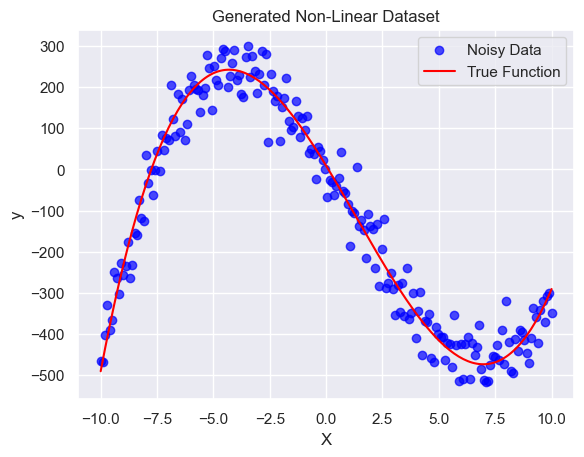

In [2]:
np.random.seed(42)

X = np.linspace(-10, 10, 200) # Generating 500 x values evenly spaced between -10 and 10

# Defining a random a cubic polynomial function of the form: y = ax^3 + bx^2 + cx + d
a, b, c, d = 1, -4, -90, 9
y_true = a*X**3 + b*X**2 + c*X + d

noise = np.random.normal(0, 50, X.shape) # Adding some random noise to make it realistic
y_noisy = y_true + noise

dataset = pd.DataFrame({'X': X, 'y': y_noisy})
dataset.to_csv("non_linear_dataset.csv", index=False)

plt.scatter(X, y_noisy, label="Noisy Data", color='blue', alpha = 0.7)
plt.plot(X, y_true, label="True Function", color='red')
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.title("Generated Non-Linear Dataset")
plt.show()

In [3]:
dataset = pd.read_csv("non_linear_dataset.csv")
print(dataset.columns)
print(dataset.head())

Index(['X', 'y'], dtype='object')
           X           y
0 -10.000000 -466.164292
1  -9.899497 -469.109897
2  -9.798995 -401.689697
3  -9.698492 -330.474743
4  -9.597990 -391.554595


In [4]:
X = dataset[['X']].values.reshape(-1, 1)
y = dataset['y'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [6]:
poly = PolynomialFeatures(degree=3) # Transforming input features to polynomial features (degree 3)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

polynomial_model = LinearRegression() # Training a linear regression model on transformed features
polynomial_model.fit(X_train_poly, y_train)

# Making predictions (The validation dataset’s X values are substituted into this equation to compute y^ (predicted values))
y_pred = polynomial_model.predict(X_test_poly)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

Mean Squared Error: 3034.79


### Visualizing the polynomial regression on the data

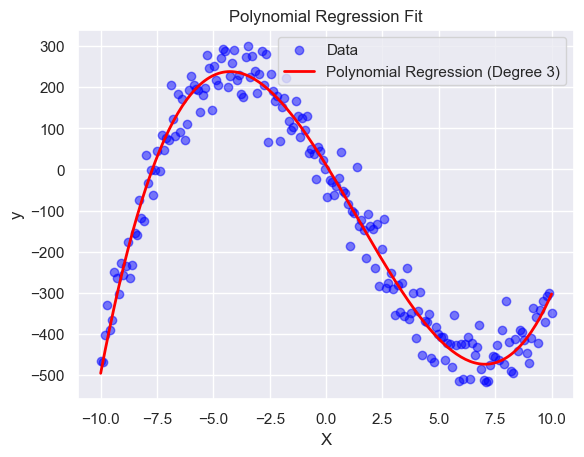

In [7]:
plt.scatter(X, y, label="Data", color='blue', alpha=0.5)
plt.plot(np.sort(X, axis=0), polynomial_model.predict(poly.transform(np.sort(X, axis=0))), 
         label="Polynomial Regression (Degree 3)", color='red', linewidth=2)
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.title("Polynomial Regression Fit")
plt.show()

## Q22: Implement multiple linear regression model for house price detection data available on Moodle using Scikit learn, check for R2 and Adjusted R2. Also perform data preprocessing, such as feature scaling, hot encoding if needed.

In [8]:
House_df = pd.read_csv("House price prediction data.csv")

House_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   price                         545 non-null    int64 
 1   area                          545 non-null    int64 
 2   bedrooms                      545 non-null    int64 
 3   bathrooms                     545 non-null    int64 
 4   stories                       545 non-null    int64 
 5   mainroad                      545 non-null    object
 6   guestroom                     545 non-null    object
 7   basement                      545 non-null    object
 8   hotwaterheating               545 non-null    object
 9   airconditioning               545 non-null    object
 10  parking                       545 non-null    int64 
 11  preferred area (city center)  545 non-null    object
 12  furnishingstatus              545 non-null    object
dtypes: int64(6), object(

In [9]:
House_df.head(5)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,preferred area (city center),furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


R² Score: 0.62
Adjusted R² Score: 0.57


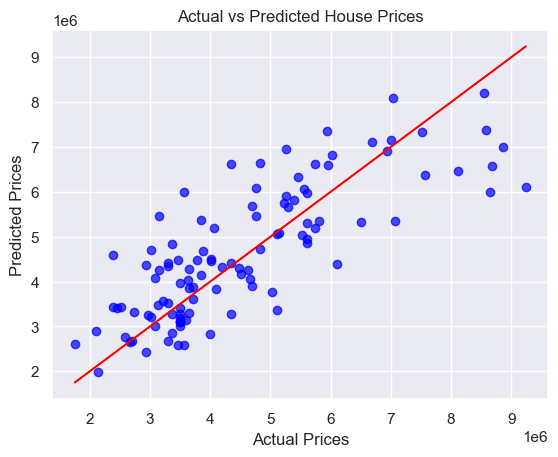

In [10]:
House_df = pd.read_csv("House price prediction data.csv")

# Step 1: Encoding Categorical Variables
# "yes"/"no" columns into 0 and 1
binary_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'preferred area (city center)']
for col in binary_cols:
    House_df[col] = House_df[col].map({'yes': 1, 'no': 0})

# One-hot encoding "furnishingstatus" (since it has 3 categories)
categorical_col = ['furnishingstatus']

# OneHotEncoder of SKlearn
encoder = OneHotEncoder(drop='first', sparse_output=False)  # drop='first' avoids multicollinearity

# Fit and transform the column
encoded_array = encoder.fit_transform(House_df[categorical_col])
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_col)) # Converting to pandas DataFrame

# Dropping original column and concatenate new one-hot encoded columns
House_df = House_df.drop(columns=categorical_col).reset_index(drop=True)
House_df = pd.concat([House_df, encoded_df], axis=1)

# Step 2: Defining Features and Target Variable
X = House_df.drop(columns=['price'])  # Features excluding the target variable
y = House_df['price']  # Target

# Step 3: Built in feature scaling (Standardization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=23)

# Step 5: Train Multiple Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 6: Predictions and Model Evaluation
y_pred = model.predict(X_test)

# R-squared (R²) Score
r2 = r2_score(y_test, y_pred)

# Adjusted R² Calculation:
n = X_test.shape[0]  # of observations
p = X_test.shape[1]  # of predictors
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"R² Score: {r2:.2f}")
print(f"Adjusted R² Score: {adjusted_r2:.2f}")

# Step 7: Visualizing Predictions vs Actual Values
plt.scatter(y_test, y_pred, color='blue', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted House Prices")
plt.show()

---
## Q23: Generate linear data with two classes, and create a logistic regression model using Scikit learn

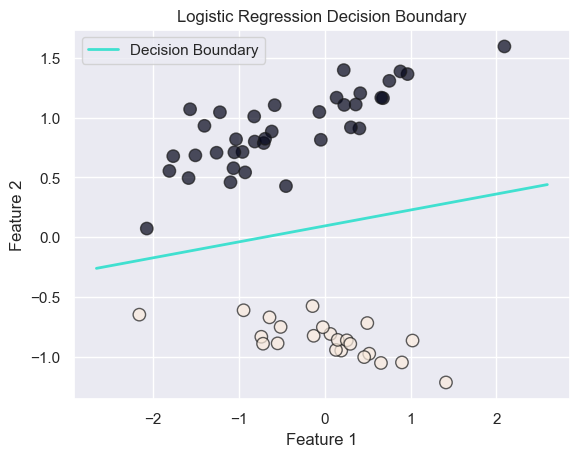

In [23]:
# Generatingg linearly separable data with two classes
X, y = make_classification(
    n_samples=300,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_classes=2,
    n_clusters_per_class=1,
    class_sep=1.8)  # <- This parameter helps defining linear separability

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Standardization of features for better model performance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Training the model
logis_model = LogisticRegression()
logis_model.fit(X_train, y_train)

def plt_decision_boundary(logis_model, X, y):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    coef = logis_model.coef_[0]
    intercept = logis_model.intercept_[0]
    x_vals = np.linspace(x_min, x_max, 100)
    y_vals = -(coef[0] * x_vals + intercept) / coef[1]  # This is the same wX + b = 0
                                                        # (where  w  and  b  are learned by gradient descent under the hood of scikit learn's model)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors="k", s=80, alpha=0.7)
    plt.plot(x_vals, y_vals, "turquoise", linewidth=2, label="Decision Boundary")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.title("Logistic Regression Decision Boundary")
    plt.show()

plt_decision_boundary(logis_model, X_test, y_test)

---
## Q24: Generate a non linear data with two classes, and create a logistic regression model using Scikit learn.

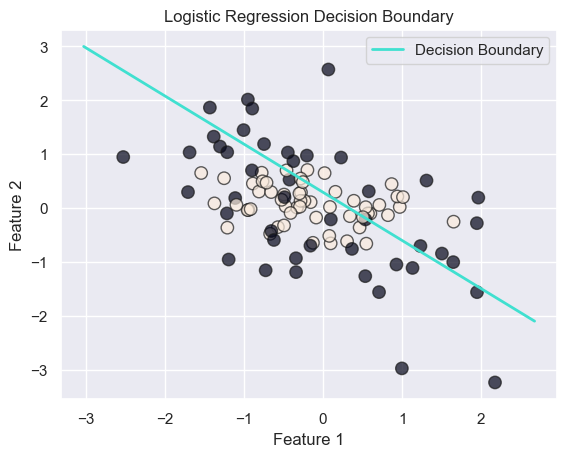

In [12]:
# Generatingg non-linear data with two classes
X, y = make_classification(
    n_samples=500,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_classes=2,
    n_clusters_per_class=1,
    class_sep=0.01)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

logis_model = LogisticRegression()
logis_model.fit(X_train, y_train)

plt_decision_boundary(logis_model, X_test, y_test)

---
## Q25: Train an SVM classifier on the MNIST dataset. Since SVM classifiers are binary classifiers, you will need to use one-versus-all to classify all 10 digits. 
- You may want to tune the hyperparameters using small validation sets to speed up the process.
- What accuracy can you reach?

In [16]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [17]:
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(y_test.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


In [18]:
# Flatten images (28x28) to vectors (784 features)
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Normalization of pixel values from (0-255) to (0-1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 2: Reducing the Training Size (Speed Optimization)
# Selecting a smaller subset (e.g., 10,000 samples for tuning)
X_train_small, _, y_train_small, _ = train_test_split(X_train, y_train, train_size=10000, random_state=42, stratify=y_train)

# Reducing Dimensions using PCA
pca = PCA(n_components=150)  # Reducing to 150 components (~95% variance)
X_train_small_pca = pca.fit_transform(X_train_small)
X_test_pca = pca.transform(X_test)  # Applying the same transformation to the test set

In [19]:
# Tuning Hyperparameters on a Small Validation Set
param_grid = {'C': [1, 10, 50], 'gamma': [0.001, 0.01, 0.1]}
grid_search = GridSearchCV(SVC(kernel='rbf', decision_function_shape='ovr'), param_grid, cv=3, n_jobs=-1) # GridSearchCV is a technique 
                    # of finding the optimal parameter values from a given set of parameters in a grid. It is essentially a cross-validation technique
grid_search.fit(X_train_small_pca, y_train_small)

# Best parameters found
best_C = grid_search.best_params_['C']
best_gamma = grid_search.best_params_['gamma']
print(f"Best hyperparameters: C={best_C}, gamma={best_gamma}")

# Training the Final Model on Full Training Set with PCA
svm = SVC(kernel='rbf', C=best_C, gamma=best_gamma, decision_function_shape='ovr')
svm.fit(X_train_small_pca, y_train_small)  # Train on reduced dataset for speed

# Evaluatinh the Model
y_test_pred = svm.predict(X_test_pca)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Test Accuracy with PCA & optimized SVM: {test_accuracy:.4f}")

Best hyperparameters: C=10, gamma=0.001
Test Accuracy with PCA & optimized SVM: 0.9557


## Q26: Generate a non-linear data set with two classes. Implement SVM model to classify this non-linear data set using kernel trick.

Test Accuracy: 0.96


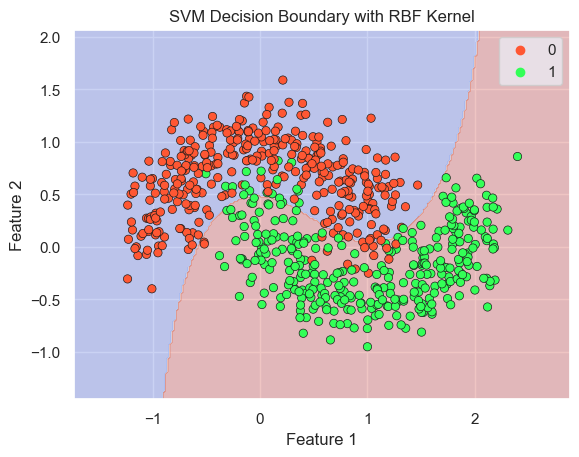

In [20]:
X, y = make_moons(n_samples=700, noise=0.2, random_state=42) # non-linear dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training SVM with an RBF kernel
svm_model = SVC(kernel='rbf', gamma='auto', C=1.0)
svm_model.fit(X_train, y_train)

# Predicts on test set
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

def plt_decision_boundary(model, X, y):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette=['#FF5733', '#33FF57'], edgecolor='k')
    plt.title("SVM Decision Boundary with RBF Kernel")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

plt_decision_boundary(svm_model, X, y)